# Introduction

In this notebook, we'll walk through some of the basic tools we'll be using to handle audio data.

## The `AudioSignal` Object

We'll use the [`Descript-AudioTools`](https://github.com/descriptinc/audiotools) library to handle audio data. The main feature of this library is encapsulating audio data in an `AudioSignal` object, with support for file I/O and common operations such as resampling. Fundamentally, an `AudioSignal` acts as a wrapper around a PyTorch tensor of shape `(batch_size, num_channels, num_samples)`.

duration: 5.323 seconds
batch_size: 1
path: /home/patrick/wm_tutorial/assets/audio/bryan_0.wav
sample_rate: 24000
num_channels: 1
audio_data.shape: torch.Size([1, 1, 127744])
stft_params: STFTParams(window_length=1024, hop_length=256, window_type='hann', match_stride=False, padding_type='reflect')
device: cpu




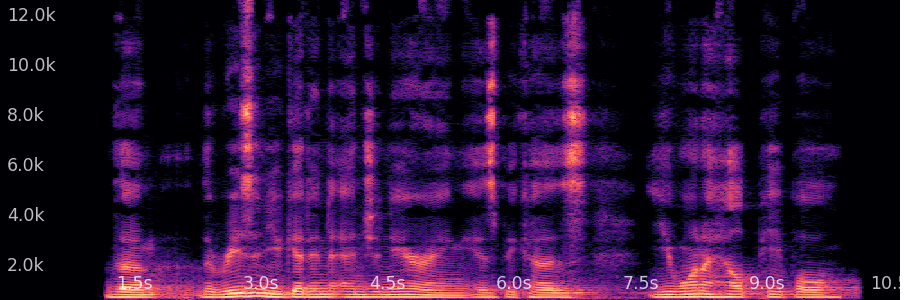
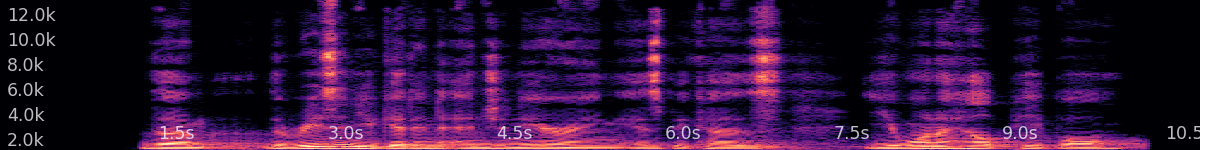

In [1]:
from pathlib import Path
from audiotools import AudioSignal

from wm_tutorial.constants import DATA_DIR, ASSETS_DIR

# Load audio data by providing either a filepath or array (and sample rate)
signal = AudioSignal(ASSETS_DIR / "audio" / "bryan_0.wav")

# Display some information stored in an AudioSignal object
print(signal)

# Display a playable widget with spectrogram plot
signal.widget()

We can easily access the audio tensor stored within an `AudioSignal` object via `.audio_data`. The `AudioSignal` class wraps many of the standard tensor methods and attributes for easy access, and introduces additional helpful attributes.

In [45]:
# Wrappers for shape / device / etc.
print("Stored data shape:", signal.audio_data.shape, " / AudioSignal shape:", signal.shape)
print("Stored data device:", signal.audio_data.device, " / AudioSignal device:", signal.device)

# Sample rate and other helpful attributes
print("AudioSignal sample rate:", signal.sample_rate)
print("AudioSignal duration (seconds):", signal.duration)
print("AudioSignal channel count:", signal.num_channels)
print("AudioSignal source file path:", signal.path_to_file)

Stored data shape: torch.Size([1, 1, 127744])  / AudioSignal shape: torch.Size([1, 1, 127744])
Stored data device: cpu  / AudioSignal device: cpu
AudioSignal sample rate: 24000
AudioSignal duration (seconds): 5.322666666666667
AudioSignal channel count: 1
AudioSignal source file path: /tmp/tmpdhwu9jum.wav


The `AudioSignal` class also supports a number of standard operations such as resampling, filtering, and padding.


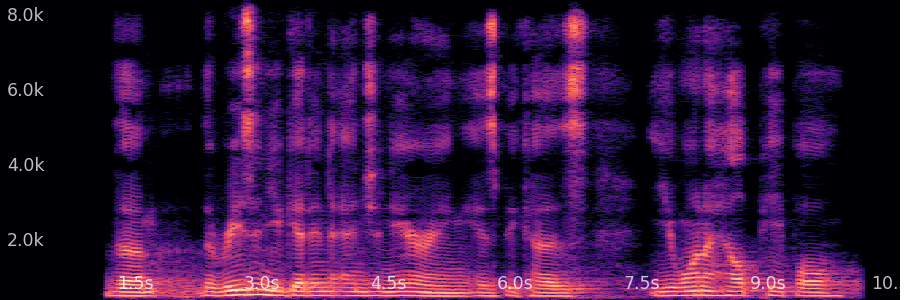
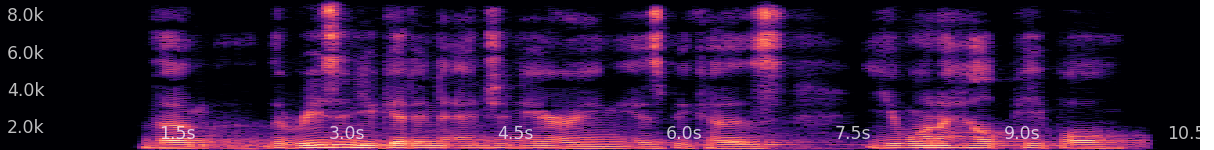

In [49]:
resampled = signal.clone().resample(16000)
resampled.widget()


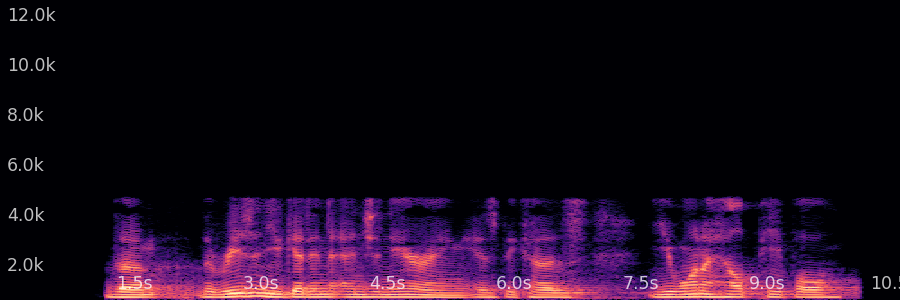
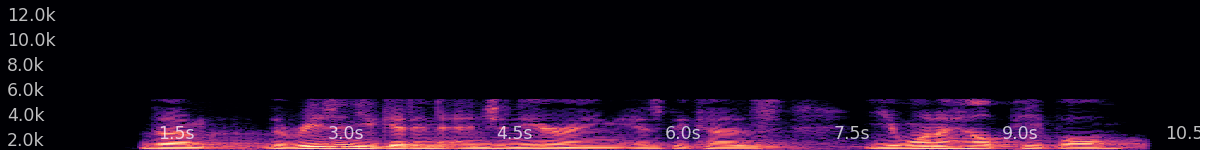

In [50]:
filtered = signal.clone().low_pass(4000)
filtered.widget()

Finally, the `AudioSignal` class includes helpful feature extraction utilities, including spectrograms.

Spectrogram parameters: STFTParams(window_length=1024, hop_length=512, window_type='hann', match_stride=False, padding_type='reflect')
Spectrogram shape (batch_size, num_channels, num_freq, num_frames): torch.Size([1, 1, 513, 250])

Spectrogram parameters: STFTParams(window_length=1024, hop_length=512, window_type='hann', match_stride=False, padding_type='reflect')
Spectrogram shape (batch_size, num_channels, num_freq, num_frames): torch.Size([1, 1, 513, 250])

Cached STFT data: torch.Size([1, 1, 513, 250])

Magnitude spectrogram: torch.Size([1, 1, 513, 250])


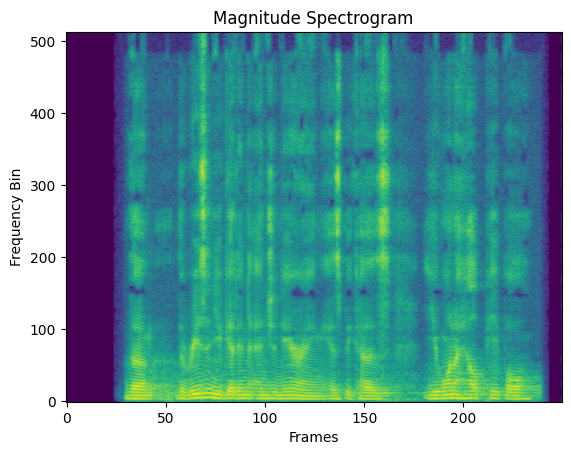

Phase spectrogram: torch.Size([1, 1, 513, 250])


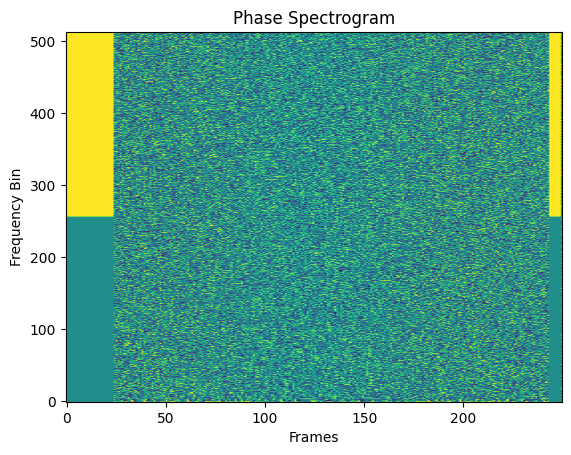

In [74]:
from audiotools import STFTParams
import matplotlib.pyplot as plt
%matplotlib inline

# Check stored spectrogram parameters
print("Spectrogram parameters:", signal.stft_params)

# Compute a complex-valued spectrogram
spec = signal.stft()
print("Spectrogram shape (batch_size, num_channels, num_freq, num_frames):", spec.shape)

# Use different spectrogram parameters
signal.stft_params = STFTParams(
    window_length=1024, 
    hop_length=512
)
print("\nSpectrogram parameters:", signal.stft_params)

# Compute a complex-valued spectrogram
spec = signal.stft()
print("Spectrogram shape (batch_size, num_channels, num_freq, num_frames):", spec.shape)

# Access cached spectrogram data
print("\nCached STFT data:", signal.stft_data.shape)

# Obtain (real-valued) magnitude spectrogram from cached data
print("\nMagnitude spectrogram:", signal.magnitude.shape)
plt.imshow(signal.magnitude[0, 0].clamp(min=1e-5).log(), origin="lower", aspect="auto")
plt.xlabel("Frames")
plt.ylabel("Frequency Bin")
plt.title("Magnitude Spectrogram")
plt.show()

# Obtain (real-valued) phase spectrogram from cached data
print("Phase spectrogram:", signal.phase.shape)
plt.imshow(signal.phase[0, 0], origin="lower", aspect="auto")
plt.xlabel("Frames")
plt.ylabel("Frequency Bin")
plt.title("Phase Spectrogram")
plt.show()

## Datasets

For training and evaluating our watermarking systems, we will use the [LibriTTS-R dataset](https://www.openslr.org/141/), a ["restored" version](https://arxiv.org/abs/2305.18802) of the [LibriTTS](https://arxiv.org/abs/1904.02882) dataset. This dataset contains read speech sampled at 24kHz, processed with the [Miipher](https://arxiv.org/abs/2303.01664) audio restoration algorithm to remove noise.

__Make sure you've run `scripts/download_data.sh` before executing this cell!__

In [91]:
from audiotools.data.datasets import AudioLoader, AudioDataset

# Choose our dataset sample rate. Audio will automatically be resampled to this
# rate when loaded from disk
sample_rate = 16_000

# The AudioTools AudioDataset object wraps an AudioLoader object that reads 
# files from disk
loader = AudioLoader(sources=[DATA_DIR/"LibriTTS_R"])
dataset = AudioDataset(
    loader, 
    sample_rate=sample_rate,
    n_examples=1_000,           # Number of unique rows to load
    duration=5.0,               # Pad/trim all audio to this duration
    loudness_cutoff=-40,        # Sample random excerpts until minimum loudness (dB) cutoff is met
    num_channels=1,             # If 1, downmix all audio to mono
    without_replacement=False,  # Sample audio files with/without replacement
)

# Grab a single row from our dataset
dataset[0]

{'idx': 0,
 'signal': <audiotools.core.audio_signal.AudioSignal at 0x7ffab0fef460>,
 'source_idx': 0,
 'item_idx': 305711,
 'source': '/home/patrick/wm_tutorial/data/LibriTTS_R',
 'path': '/home/patrick/wm_tutorial/data/LibriTTS_R/train-other-500/6324/64063/6324_64063_000003_000002.wav'}

As we can see, each row in our dataset is a dictionary holding an `AudioSignal` object (`signal`) and various metadata.

## Batched Data Loading

For training and evaluating our watermarking systems, we will want to process batches of audio signals in parallel. This means pointing a PyTorch dataloader object at our dataset and providing it with a collation function for combining rows (dictionaries) into batches. Luckily, `AudioTools` provides this function as an attribute of dataset objects.

In [92]:
from torch.utils.data import DataLoader

# Initialize data loader
dataloader = DataLoader(
    dataset,
    batch_size=8,
    collate_fn=dataset.collate,
)

# Grab a batch
batch = next(iter(dataloader))
print(batch)

{'idx': tensor([0, 1, 2, 3, 4, 5, 6, 7]), 'signal': <audiotools.core.audio_signal.AudioSignal object at 0x7ffab10084c0>, 'source_idx': tensor([0, 0, 0, 0, 0, 0, 0, 0]), 'item_idx': tensor([305711, 128037, 351400,  71530, 120705, 297827, 162698,  61615]), 'source': ['/home/patrick/wm_tutorial/data/LibriTTS_R', '/home/patrick/wm_tutorial/data/LibriTTS_R', '/home/patrick/wm_tutorial/data/LibriTTS_R', '/home/patrick/wm_tutorial/data/LibriTTS_R', '/home/patrick/wm_tutorial/data/LibriTTS_R', '/home/patrick/wm_tutorial/data/LibriTTS_R', '/home/patrick/wm_tutorial/data/LibriTTS_R', '/home/patrick/wm_tutorial/data/LibriTTS_R'], 'path': ['/home/patrick/wm_tutorial/data/LibriTTS_R/train-other-500/6324/64063/6324_64063_000003_000002.wav', '/home/patrick/wm_tutorial/data/LibriTTS_R/train-clean-360/6317/54487/6317_54487_000027_000004.wav', '/home/patrick/wm_tutorial/data/LibriTTS_R/train-other-500/7997/111638/7997_111638_000005_000004.wav', '/home/patrick/wm_tutorial/data/LibriTTS_R/train-clean-360/

Note that our `AudioSignal` objects have been combined into a single batched `AudioSignal` object, i.e. padded to a uniform length along the final tensor dimension and then concatenated alongthe first tensor dimension.

In [93]:
# Inspect our batched AudioSignal
print(batch["signal"])

duration: 5.000 seconds
batch_size: 8
path: ['/home/patrick/wm_tutorial/data/LibriTTS_R/train-other-500/6324/64063/6324_64063_000003_000002.wav', '/home/patrick/wm_tutorial/data/LibriTTS_R/train-clean-360/6317/54487/6317_54487_000027_000004.wav', '/home/patrick/wm_tutorial/data/LibriTTS_R/train-other-500/7997/111638/7997_111638_000005_000004.wav', '/home/patrick/wm_tutorial/data/LibriTTS_R/train-clean-360/209/4731/209_4731_000016_000001.wav', '/home/patrick/wm_tutorial/data/LibriTTS_R/train-clean-360/5802/76044/5802_76044_000041_000000.wav', '/home/patrick/wm_tutorial/data/LibriTTS_R/train-other-500/6076/51653/6076_51653_000011_000007.wav', '/home/patrick/wm_tutorial/data/LibriTTS_R/train-clean-360/8534/216564/8534_216564_000010_000001.wav', '/home/patrick/wm_tutorial/data/LibriTTS_R/train-clean-360/1425/139297/1425_139297_000000_000000.wav']
sample_rate: 16000
num_channels: 1
audio_data.shape: torch.Size([8, 1, 80000])
stft_params: STFTParams(window_length=512, hop_length=128, window_